In [1]:
import requests
import json
import pandas as pd
import plotly.express as px 
import plotly.graph_objects as go
from IPython.core.display import display, HTML
import os
from os import path

In [2]:
html_dir = "../../../docs/graphs/transparency_report/"
if not path.exists(html_dir):
    try:
        os.makedirs(html_dir)
    except:
        print("Could not make directory")
        exit(1)

In [3]:
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return True

def read_data(path):
    data = []
    with open(path, errors='ignore') as f:
        for line in f.readlines():
            try: 
                if not is_json(line):
                    continue
                data.append(json.loads(line))
            except:
                print('bad json: ', line)
    return data

def get_data(link, feature):
    res = requests.get(link)
    data = json.loads(res.content)
    df = pd.DataFrame(data.items(), columns=['date', feature])  
    
    return df

def draw_graph(df, feature, name, title):
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "")

    fig = px.line(df, x='date', y=feature, color_discrete_sequence = ['#99d6ff'], title = 'Harmony {} Chart'.format(title))
    fig.update_xaxes({'showgrid': False, 'showspikes': True, 'title': None})
    fig.update_yaxes({'gridcolor': "#E8E8E8"})
    fig.update_layout({'plot_bgcolor':'rgba(0,0,0,0)', "title_x": 0.5, 'hovermode': 'closest'})
#     fig.show(renderer="svg",width=800, height=500)
    fig.write_html("{:s}{:s}.html".format(html_dir, name))
    print("HTML saved in " )
    display_path = "{:s}{:s}.html".format(html_path, name)
    display(HTML("<a href='" + display_path + "' target='_blank'>" + display_path + "</a>"))
    return fig

## Daily Transaction

HTML saved in 


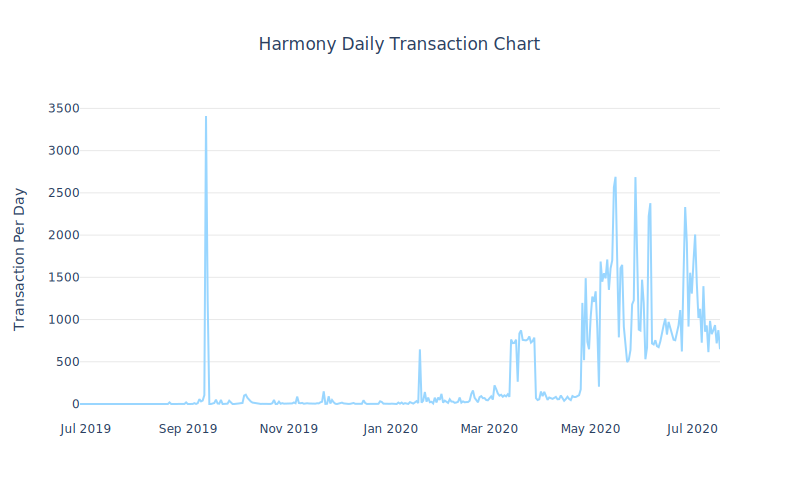

In [4]:
link = "https://harmony-explorer-mainnet.firebaseio.com/total-txs-count.json"
feature = 'Harmony Cumulative Transaction Growth'
df = get_data(link, feature)
df['Daily Increase'] = (df[feature]-df[feature].shift()).fillna(0).astype(int)
new_df = df[['date','Daily Increase']].loc[1:]
new_df['date'] = pd.to_datetime(new_df['date'],format ='%Y_%m_%d')

old_df = pd.read_csv("../data/daily_txs.csv", header = 0)
old_df = old_df[old_df['date'] < '2020-07-07']
old_df.rename(columns = {'txs-count':'Daily Increase'}, inplace = True)
old_df['date'] = pd.to_datetime(old_df['date'],format ='%Y-%m-%d')

merge_df = pd.concat([old_df, new_df], axis=0)
merge_df.reset_index(drop = True, inplace = True)
fig = draw_graph(merge_df, 'Daily Increase', "daily_txs_count", "Daily Transaction")
fig.update_layout(yaxis_title="Transaction Per Day")
fig.show(renderer="svg",width=800, height=500)

## Staking Transaction

HTML saved in 


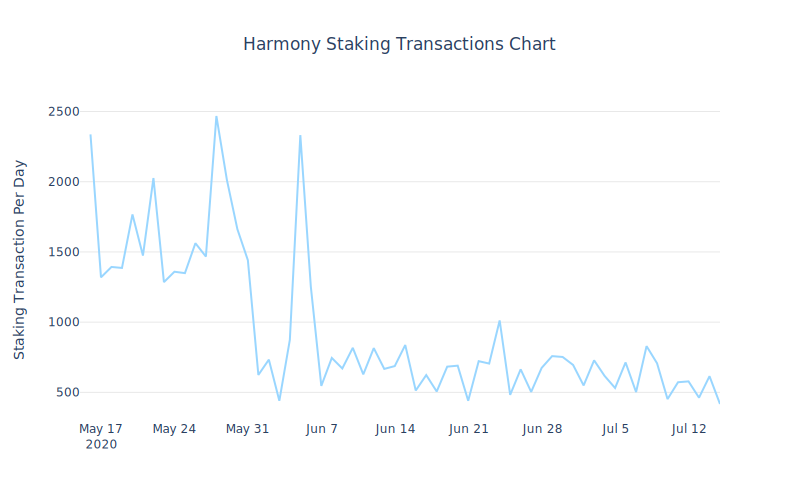

In [5]:
log_dir = "../logs/stakingTxsCount.log"
data = read_data(log_dir)
df = pd.DataFrame(data) 
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y_%m_%d %H:%M:%S')
df['date'] = df['timestamp'].dt.date
staking_df = df.groupby(['date'])['count'].max().reset_index(name = 'staking_txs_count')
staking_df = staking_df[:-2]
link = "https://harmony-explorer-mainnet.firebaseio.com/daily-stakingTxs-count.json"
feature = 'staking_txs_count'
new_df = get_data(link, feature)
merge_df = pd.concat([staking_df, new_df], axis=0)
merge_df.reset_index(drop = True, inplace = True)
merge_df['daily_staking_txs_count'] = merge_df["staking_txs_count"]- merge_df["staking_txs_count"].shift()

fig = draw_graph(merge_df, "daily_staking_txs_count", "daily_staking_txs_count", "Staking Transactions")
fig.update_layout(yaxis_title="Staking Transaction Per Day")
fig.show(renderer="svg",width=800, height=500)